In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame

import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [3]:
job_desc_df = pd.read_csv('ScrappedDataToCSV/NLP_filtered_job_desc.csv')

### Performing text analysis,
- tokenize + filter + stemming + categorize tool/skill

In [4]:
# trimming down the job description
for i in range(len(job_desc_df)):
    desc_list = job_desc_df['description'].iloc[i].split('\n')
    # majority of job requirements and responsibility lines have a length of 45 and shorter
    desc_arr = [i for i in desc_list if len(i) > 45]
    joined_desc = ' '.join(desc_arr)
    job_desc_df['description'].at[i] = joined_desc

In [5]:
# helper function
ps = PorterStemmer()
wanted_tag = ['NN', 'JJ', 'VBP']

def preppingJobDesc(desc):
    tokens = word_tokenize(desc.lower())
    token_tag = pos_tag(tokens)
    filtered_tokens = [tok for tok, tag in token_tag if tag in wanted_tag]
    stemmed_tokens = [ps.stem(tok).lower() for tok in filtered_tokens]
    return set(stemmed_tokens)

In [6]:
# common list of tools and skills appeared in many postings from a quick glance.
tool_skill = ['server',
              'cloud',
              'sql',
              'mysql',
              'python',
              'r',
              'tableau',
              'power bi',
              'looker',
              'powerpoint',
              'sheet',
              'gsuite',
              'jupyter',
              'javascript',
              'java',
              'excel',
              'statistic',
              'model',
              'word',
              'bi']

job_desc_df['desc_word_set'] = job_desc_df['description'].map(preppingJobDesc)
tool_keyword_set = set([ps.stem(tok) for tok in tool_skill]) # using set since we cant have duplicates
tool_keyword_dict = {ps.stem(tok):tok for tok in tool_skill} 

In [7]:
# create a list of all the tools asked in the job description

tool_list = []
num_of_jobs = len(job_desc_df)

for i in range(num_of_jobs):
    desc_word_set = job_desc_df['desc_word_set'].iloc[i]
    tool_word_intersect = tool_keyword_set.intersection(desc_word_set)
    
    if len(tool_word_intersect) == 0:
        tool_list.append('Not Specified')
        
    tool_list += list(tool_word_intersect)

In [8]:
# creating a dataframe from results
df_tool = pd.DataFrame(data = {'count': tool_list})
df_tool = df_tool.replace(tool_keyword_dict)

# matching keywords for the samething.
temp = df_tool['count'] == 'bi'
df_tool.loc[temp,'count'] = 'power bi'

temp = df_tool['count'] == 'mysql'
df_tool.loc[temp,'count'] = 'sql'

df_tool = df_tool.value_counts().reset_index().rename(columns = {'count':'tool', 0:'count'})

### Quick visual using seaborn

<ipython-input-10-4dc7ee97d0fa>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(['{:,.0%}'.format(x) for x in bins])


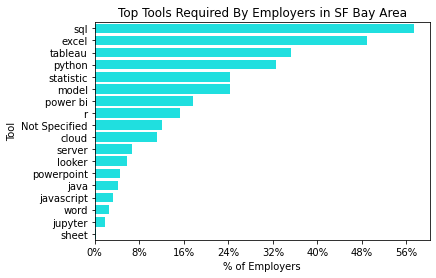

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

highest_perc = round(df_tool['count'].iloc[0] / len(job_desc_df), 2)
bins = np.arange(0,highest_perc, .08)
plot = sns.barplot(data = df_tool, x = df_tool['count'], y = df_tool['tool'], color = 'cyan')
plot.set(xlabel = '% of Employers', ylabel = 'Tool', title = 'Top Tools Required By Employers in SF Bay Area')
plot.set_xticklabels(['{:,.0%}'.format(x) for x in bins])
plt.savefig('Top Tools', format = 'png')